In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from os.path import expanduser
import argparse
import csv
import sys
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

In [2]:
from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

In [3]:
def defaultSupplFile():
  return '%s/chembl_19/chembl_19.sdf' % datadir

def saveFingerprints(results, filename):
  """ results is a dictionary: chembl_id -> [fingerprints] """
  with open(filename, 'w') as csvfile:
    fpwriter = csv.writer(csvfile, delimiter=",", quoting=csv.QUOTE_NONE)
    fpwriter.writerow(["compound","feature"])
    for compound in results:
        for feature in results[compound]:
            fpwriter.writerow( [compound, feature] )

def saveFingerprintsNpy(results, filename, cmpdlist, ecfp_fold=32000):
    """ write fingerprints to a npy """
    fp2 =[(x,(np.array(list(results[x].keys())), np.array(list(results[x].values())))) for x in results] #TODO: Modify to save compound list
    cmpd, ecfp   = zip(*fp2)
    feat, counts = zip(*ecfp)
    lens    = np.array([len(f) for f in feat])
    indptr  = np.concatenate([[0], np.cumsum(lens)])
    indices = np.concatenate(feat) % ecfp_fold
    data = np.ones(indices.shape[0])
    csr = csr_matrix((data, indices, indptr), shape=(len(feat), ecfp_fold))
    csr.sum_duplicates()
    csr.data[:] = 1.0

    np.save(filename, csr)
    pd.DataFrame(cmpd).to_csv(cmpdlist, header=False)
       

In [4]:
def getChemblIDs(ic50file):
  a = pd.read_csv(ic50file, header = None)
  chembl = a[0].values 
  return chembl

In [5]:
def printMol(mol, width = 450, height = 150):
    bits = AllChem.GetMorganFingerprint(mol, 3) 
    print ('Chembl-id:    %s' % mol.GetProp('chembl_id'))
    print ('Num of Atoms: %d' % mol.GetNumAtoms())
    print ("#bits:        %d" % len(bits.GetNonzeroElements()))
    print ('Smiles:       %s' % Chem.MolToSmiles(mol, isomericSmiles=True))
    print ("")
    drawMol(mol, width, height)


In [6]:
def drawMol(mol, width = 450, height = 150):
#     molSize = (width, height)
    mc = Chem.Mol(mol.ToBinary())

    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)

    drawer = rdMolDraw2D.MolDraw2DSVG(width, height)
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    display(SVG(svg.replace('svg:','')))

In [7]:
def whatisthis(s):
    if isinstance(s, str):
        print("ordinary string")
    elif isinstance(s, unicode):
        print ("unicode string")
    else:
        print ("not a string")

In [8]:
class SDF:
  def __init__(self, supplFile):
    self.supplFile = supplFile
    print("supplFile: ", supplFile)
    self.suppl = Chem.SDMolSupplier( self.supplFile)
    print('Total number of molcules loaded: ', len(self.suppl))

  def getMol(self, n = 10e+9):
    """ function for looping over all molecules """
    self.suppl.reset()
    i = 0
    for rdmol in self.suppl:
      if rdmol is None: continue
      i += 1
      yield rdmol
      if i >= n: return

  def print4Mol(self):
    for mol in self.getMol(4):
      print(type(mol)) 
      bits = AllChem.GetMorganFingerprint(mol, 3) 
      print ('Chembl-id: %s' % mol.GetProp('chembl_id'))
      print ("#bits:     %d" % len(bits.GetNonzeroElements()))
      print ('Smiles:    %s' % Chem.MolToSmiles(mol, isomericSmiles=True))
      print ("")

  def getMorganFingerPrints(self, chemblIDs, nMorgan):
    ids = set(chemblIDs)
    results = dict()
    i=0
    for mol in self.getMol():
      i+=1
      if i %20000 == 0:
          print("Processed: %d compounds"%i)
      chembl_id = mol.GetProp('chembl_id') 
      if chembl_id not in ids:
        continue
      results[chembl_id] = AllChem.GetMorganFingerprint(mol, nMorgan).GetNonzeroElements()
    return results

  def getMorganFingerPrintsAll(self, nMorgan):
    results = dict()
    for mol in self.getMol():
      chembl_id = mol.GetProp('chembl_id') 
      results[chembl_id] = AllChem.GetMorganFingerprint(mol, nMorgan).GetNonzeroElements()
    return results
##### end of class SDF ######

In [9]:
  parser = argparse.ArgumentParser(description='Generate Morgan(3) fingerprints from raw SDF.')
  parser.add_argument('-c', '--compounds', metavar='FILE', help="CSV file of compounds (CHEMBL IDs). If not supplied all compounds are saved.", default=None)
  parser.add_argument('-s', '--sdf', help="Input SDF file.", required=True)
  parser.add_argument('-o', '--out', help="Output file name (CSV file of fingerprints).", required=True)
  parser.add_argument('-r', '--radius', metavar='R', type=int, help="ECFP radius (default 3)", default=3)
  parser.add_argument('--numids', action='store_true')

_StoreTrueAction(option_strings=['--numids'], dest='numids', nargs=0, const=True, default=False, type=None, choices=None, help=None, metavar=None)

In [10]:
in_args = "-s input/chembl_29.sdf -o output/chembl_29_X.csv -c output/chembl_29/chembl_29_compounds.csv"
in_args = in_args.split()
print(in_args)

['-s', 'input/chembl_29.sdf', '-o', 'output/chembl_29_X.csv', '-c', 'output/chembl_29/chembl_29_compounds.csv']


In [11]:
args = vars(parser.parse_args(in_args))
args
# args_sdf = args['sdf'].encode('utf-8')
# args_sdf = args['sdf'].encode('utf-8').decode('ascii')
# args_sdf

{'compounds': 'output/chembl_29/chembl_29_compounds.csv',
 'sdf': 'input/chembl_29.sdf',
 'out': 'output/chembl_29_X.csv',
 'radius': 3,
 'numids': False}

In [12]:
sdf = SDF(args['sdf'])

supplFile:  input/chembl_29.sdf
Total number of molcules loaded:  2084724


In [13]:
sdf.suppl.reset()

In [14]:
len(sdf.suppl)

2084724

In [15]:
rdmol_gen = sdf.getMol()

In [16]:
curr_mol = next(rdmol_gen)

Chembl-id:    CHEMBL153534
Num of Atoms: 16
#bits:        45
Smiles:       Cc1cc(-c2csc(N=C(N)N)n2)cn1C



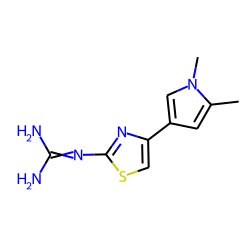

In [17]:
printMol(curr_mol, 250,250)

In [18]:
mgf = AllChem.GetMorganFingerprint(mol, 3)
print(mgf)
print(mgf.GetNonzeroElements())

NameError: name 'mol' is not defined

In [187]:
curr_mol2 = next(rdmol_gen)


Chembl-id: CHEMBL440249
#bits:     248
Smiles:    CC(C)C[C@@H]1NC(=O)CNC(=O)[C@H](c2ccc(O)cc2)NC(=O)[C@@H]([C@@H](C)O)NC(=O)[C@H](c2ccc(O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O)cc2)NC(=O)[C@@H](CCCN)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@@H](c2ccc(O)cc2)NC(=O)[C@H](c2ccc(O)cc2)NC(=O)[C@@H](C(C)C)NC(=O)[C@@H](CCCN)NC(=O)[C@@H](c2ccc(O)cc2)NC(=O)[C@@H](CNC(=O)[C@H](CC(N)=O)NC(=O)Cc2cccc3ccccc23)[C@@H](C(N)=O)OC(=O)[C@H](c2ccc(O)c(Cl)c2)NC(=O)[C@@H](C)NC1=O



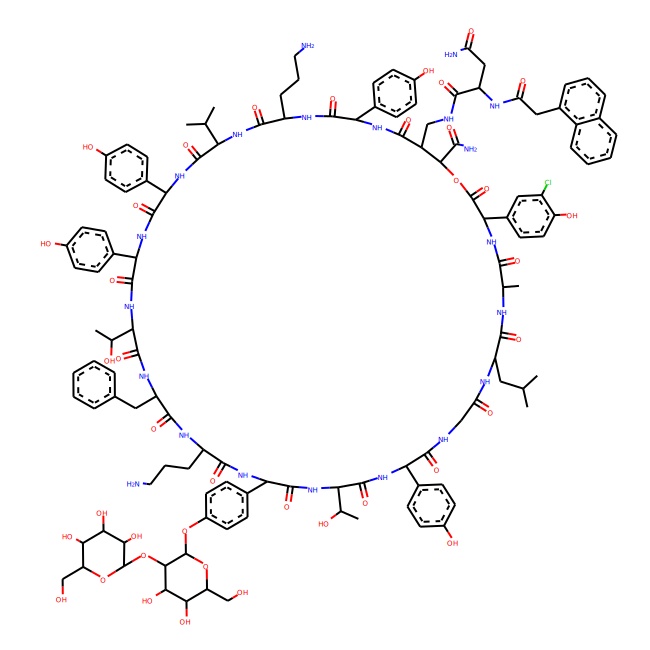

In [190]:
printMol(curr_mol2, 650, 650)

In [191]:
curr_mol3 = next(rdmol_gen)

Chembl-id: CHEMBL405398
#bits:     79
Smiles:    Brc1cccc(Nc2ncnc3ccncc23)c1NCCN1CCOCC1



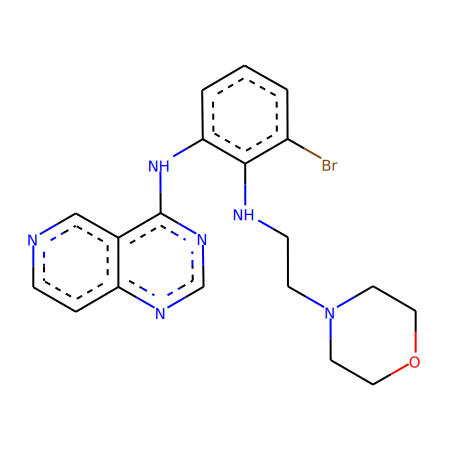

In [193]:
printMol(curr_mol3, 450,450)

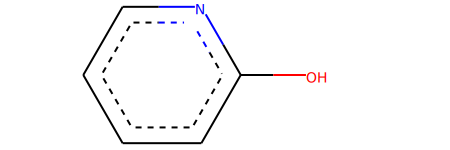

In [194]:
mol = Chem.MolFromSmiles('c1cccnc1O')
drawMol(mol)

In [205]:
print(args['compounds'])
compoundIDs = getChemblIDs(args['compounds'])
print(' Number of unique compounds: ',len(compoundIDs))
print(compoundIDs[:5])

output/chembl_29/chembl_29_compounds.csv
 Number of unique compounds:  423808
['CHEMBL1234777' 'CHEMBL1812661' 'CHEMBL1812662' 'CHEMBL2326084'
 'CHEMBL2326085']


In [206]:
fp = sdf.getMorganFingerPrints(compoundIDs[:5],3)

Processed: 20000 compounds


RDKit WARNING: [17:44:27] Warning: conflicting stereochemistry at atom 11 ignored.
[17:44:27] Warning: conflicting stereochemistry at atom 11 ignored.


Processed: 40000 compounds
Processed: 60000 compounds


RDKit WARNING: [17:44:40] Warning: conflicting stereochemistry at atom 14 ignored.
[17:44:40] Warning: conflicting stereochemistry at atom 14 ignored.


Processed: 80000 compounds


RDKit WARNING: [17:44:49] Warning: conflicting stereochemistry at atom 6 ignored.
RDKit WARNING: [17:44:49] Warning: conflicting stereochemistry at atom 6 ignored.
[17:44:49] Warning: conflicting stereochemistry at atom 6 ignored.
[17:44:49] Warning: conflicting stereochemistry at atom 6 ignored.


Processed: 100000 compounds
Processed: 120000 compounds


RDKit WARNING: [17:44:58] Warning: conflicting stereochemistry at atom 48 ignored.
[17:44:58] Warning: conflicting stereochemistry at atom 48 ignored.
RDKit WARNING: [17:44:58] Warning: conflicting stereochemistry at atom 48 ignored.
[17:44:58] Warning: conflicting stereochemistry at atom 48 ignored.
RDKit WARNING: [17:44:58] Warning: conflicting stereochemistry at atom 0 ignored.
RDKit WARNING: [17:44:58] Warning: conflicting stereochemistry at atom 0 ignored.
[17:44:58] Warning: conflicting stereochemistry at atom 0 ignored.
[17:44:58] Warning: conflicting stereochemistry at atom 0 ignored.
RDKit WARNING: [17:44:59] Warning: conflicting stereochemistry at atom 0 ignored.
[17:44:59] Warning: conflicting stereochemistry at atom 0 ignored.
RDKit WARNING: [17:44:59] Warning: conflicting stereochemistry at atom 0 ignored.
[17:44:59] Warning: conflicting stereochemistry at atom 0 ignored.


Processed: 140000 compounds
Processed: 160000 compounds
Processed: 180000 compounds
Processed: 200000 compounds
Processed: 220000 compounds
Processed: 240000 compounds
Processed: 260000 compounds
Processed: 280000 compounds
Processed: 300000 compounds
Processed: 320000 compounds


RDKit WARNING: [17:46:05] Warning: conflicting stereochemistry at atom 5 ignored.
[17:46:05] Warning: conflicting stereochemistry at atom 5 ignored.


Processed: 340000 compounds
Processed: 360000 compounds
Processed: 380000 compounds
Processed: 400000 compounds
Processed: 420000 compounds


RDKit WARNING: [17:46:38] Warning: conflicting stereochemistry at atom 26 ignored.
[17:46:38] Warning: conflicting stereochemistry at atom 26 ignored.


Processed: 440000 compounds
Processed: 460000 compounds
Processed: 480000 compounds
Processed: 500000 compounds
Processed: 520000 compounds
Processed: 540000 compounds
Processed: 560000 compounds
Processed: 580000 compounds
Processed: 600000 compounds
Processed: 620000 compounds
Processed: 640000 compounds
Processed: 660000 compounds
Processed: 680000 compounds
Processed: 700000 compounds
Processed: 720000 compounds


RDKit WARNING: [17:48:15] Warning: conflicting stereochemistry at atom 1 ignored.
RDKit WARNING: [17:48:15] Warning: conflicting stereochemistry at atom 2 ignored.
RDKit WARNING: [17:48:15] Warning: conflicting stereochemistry at atom 1 ignored.
RDKit WARNING: [17:48:15] Warning: conflicting stereochemistry at atom 2 ignored.
[17:48:15] Warning: conflicting stereochemistry at atom 1 ignored.
[17:48:15] Warning: conflicting stereochemistry at atom 2 ignored.
[17:48:15] Warning: conflicting stereochemistry at atom 1 ignored.
[17:48:15] Warning: conflicting stereochemistry at atom 2 ignored.
RDKit WARNING: [17:48:15] Warning: conflicting stereochemistry at atom 1 ignored.
[17:48:15] Warning: conflicting stereochemistry at atom 1 ignored.
RDKit WARNING: [17:48:15] Warning: conflicting stereochemistry at atom 1 ignored.
RDKit WARNING: [17:48:15] Warning: conflicting stereochemistry at atom 4 ignored.
RDKit WARNING: [17:48:15] Warning: conflicting stereochemistry at atom 4 ignored.
[17:48:15

Processed: 740000 compounds
Processed: 760000 compounds
Processed: 780000 compounds
Processed: 800000 compounds


RDKit WARNING: [17:48:42] Warning: conflicting stereochemistry at atom 5 ignored.
[17:48:42] Warning: conflicting stereochemistry at atom 5 ignored.


Processed: 820000 compounds
Processed: 840000 compounds
Processed: 860000 compounds
Processed: 880000 compounds
Processed: 900000 compounds
Processed: 920000 compounds
Processed: 940000 compounds
Processed: 960000 compounds
Processed: 980000 compounds
Processed: 1000000 compounds
Processed: 1020000 compounds
Processed: 1040000 compounds
Processed: 1060000 compounds
Processed: 1080000 compounds
Processed: 1100000 compounds
Processed: 1120000 compounds
Processed: 1140000 compounds
Processed: 1160000 compounds
Processed: 1180000 compounds
Processed: 1200000 compounds
Processed: 1220000 compounds
Processed: 1240000 compounds
Processed: 1260000 compounds
Processed: 1280000 compounds
Processed: 1300000 compounds
Processed: 1320000 compounds


RDKit WARNING: [17:51:12] WARNING: not removing hydrogen atom without neighbors
[17:51:12] WARNING: not removing hydrogen atom without neighbors


Processed: 1340000 compounds
Processed: 1360000 compounds
Processed: 1380000 compounds


RDKit WARNING: [17:51:33] Warning: conflicting stereochemistry at atom 0 ignored.
RDKit WARNING: [17:51:33] Warning: conflicting stereochemistry at atom 0 ignored.
[17:51:33] Warning: conflicting stereochemistry at atom 0 ignored.
[17:51:33] Warning: conflicting stereochemistry at atom 0 ignored.


Processed: 1400000 compounds
Processed: 1420000 compounds
Processed: 1440000 compounds
Processed: 1460000 compounds


RDKit WARNING: [17:52:03] Warning: conflicting stereochemistry at atom 13 ignored.
[17:52:03] Warning: conflicting stereochemistry at atom 13 ignored.
RDKit WARNING: [17:52:03] Warning: conflicting stereochemistry at atom 13 ignored.
[17:52:03] Warning: conflicting stereochemistry at atom 13 ignored.


Processed: 1480000 compounds
Processed: 1500000 compounds
Processed: 1520000 compounds
Processed: 1540000 compounds


RDKit WARNING: [17:52:30] WARNING: not removing hydrogen atom without neighbors
[17:52:30] WARNING: not removing hydrogen atom without neighbors


Processed: 1560000 compounds


RDKit WARNING: [17:52:38] WARNING: not removing hydrogen atom without neighbors
[17:52:38] WARNING: not removing hydrogen atom without neighbors


Processed: 1580000 compounds


RDKit WARNING: [17:52:44] WARNING: not removing hydrogen atom without neighbors
[17:52:44] WARNING: not removing hydrogen atom without neighbors


Processed: 1600000 compounds
Processed: 1620000 compounds
Processed: 1640000 compounds
Processed: 1660000 compounds
Processed: 1680000 compounds
Processed: 1700000 compounds
Processed: 1720000 compounds
Processed: 1740000 compounds
Processed: 1760000 compounds
Processed: 1780000 compounds
Processed: 1800000 compounds
Processed: 1820000 compounds
Processed: 1840000 compounds
Processed: 1860000 compounds
Processed: 1880000 compounds
Processed: 1900000 compounds
Processed: 1920000 compounds
Processed: 1940000 compounds


RDKit WARNING: [17:54:39] WARNING: not removing hydrogen atom without neighbors
[17:54:39] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:54:39] WARNING: not removing hydrogen atom without neighbors
[17:54:39] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:54:39] WARNING: not removing hydrogen atom without neighbors
[17:54:39] WARNING: not removing hydrogen atom without neighbors


Processed: 1960000 compounds
Processed: 1980000 compounds


RDKit WARNING: [17:54:50] Warning: conflicting stereochemistry at atom 84 ignored.
[17:54:50] Warning: conflicting stereochemistry at atom 84 ignored.
RDKit WARNING: [17:54:50] Warning: conflicting stereochemistry at atom 84 ignored.
[17:54:50] Warning: conflicting stereochemistry at atom 84 ignored.


Processed: 2000000 compounds
Processed: 2020000 compounds
Processed: 2040000 compounds
Processed: 2060000 compounds
Processed: 2080000 compounds


In [221]:
type(fp)

dict

In [227]:
for x in fp:
    print(' key: ', x ,' value :', fp[x])

 key:  CHEMBL1812662  value : {231908188: 1, 311369715: 1, 568485248: 1, 640334467: 1, 719273437: 1, 847957139: 1, 864662311: 3, 864942730: 1, 1033828962: 1, 1064551719: 1, 1146214010: 1, 1206482154: 1, 1211200385: 1, 1510328189: 1, 1510461303: 2, 1516486173: 2, 1533864325: 1, 1583009052: 1, 1681238019: 1, 2197104911: 1, 2245277810: 1, 2245384272: 4, 2246699815: 1, 2246728737: 1, 2445863990: 1, 2599969443: 1, 3096701258: 1, 3537123720: 1, 3609116172: 1, 3850856377: 1, 3930943943: 1}
 key:  CHEMBL1812661  value : {21411075: 1, 311369715: 1, 568485248: 1, 847957139: 1, 864662311: 3, 864942730: 1, 974683699: 1, 1064551719: 1, 1146214010: 1, 1206482154: 1, 1211200385: 1, 1510328189: 1, 1510461303: 2, 1516486173: 2, 1532373404: 1, 1533864325: 1, 1583799011: 1, 1710994835: 1, 2197104911: 1, 2245273601: 1, 2245384272: 4, 2246699815: 1, 2273576161: 1, 2368749857: 1, 2599973650: 1, 2765660118: 1, 3855312692: 1, 3956283135: 1, 4274980665: 1}
 key:  CHEMBL1234777  value : {43375061: 1, 517586202:

In [222]:
fp.keys()

dict_keys(['CHEMBL1812662', 'CHEMBL1812661', 'CHEMBL1234777', 'CHEMBL2326084', 'CHEMBL2326085'])

In [223]:
fp['CHEMBL1812662']

{231908188: 1,
 311369715: 1,
 568485248: 1,
 640334467: 1,
 719273437: 1,
 847957139: 1,
 864662311: 3,
 864942730: 1,
 1033828962: 1,
 1064551719: 1,
 1146214010: 1,
 1206482154: 1,
 1211200385: 1,
 1510328189: 1,
 1510461303: 2,
 1516486173: 2,
 1533864325: 1,
 1583009052: 1,
 1681238019: 1,
 2197104911: 1,
 2245277810: 1,
 2245384272: 4,
 2246699815: 1,
 2246728737: 1,
 2445863990: 1,
 2599969443: 1,
 3096701258: 1,
 3537123720: 1,
 3609116172: 1,
 3850856377: 1,
 3930943943: 1}

In [225]:
   fp2 =[(x,(np.array(list(fp[x].keys())), np.array(list(fp[x].values())))) for x in fp] 

In [230]:
print(type(fp2))

<class 'list'>


In [243]:
for x in fp2:
    print(' key: ', x[0], '\n ', x[1][0], ' \n ', x[1][1] )

 key:  CHEMBL1812662 
  [ 231908188  311369715  568485248  640334467  719273437  847957139
  864662311  864942730 1033828962 1064551719 1146214010 1206482154
 1211200385 1510328189 1510461303 1516486173 1533864325 1583009052
 1681238019 2197104911 2245277810 2245384272 2246699815 2246728737
 2445863990 2599969443 3096701258 3537123720 3609116172 3850856377
 3930943943]  
  [1 1 1 1 1 1 3 1 1 1 1 1 1 1 2 2 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1]
 key:  CHEMBL1812661 
  [  21411075  311369715  568485248  847957139  864662311  864942730
  974683699 1064551719 1146214010 1206482154 1211200385 1510328189
 1510461303 1516486173 1532373404 1533864325 1583799011 1710994835
 2197104911 2245273601 2245384272 2246699815 2273576161 2368749857
 2599973650 2765660118 3855312692 3956283135 4274980665]  
  [1 1 1 1 3 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1]
 key:  CHEMBL1234777 
  [  43375061  517586202  680739744  717512901  787069595  847957139
  847961216  849275503  857075109  864662311  864942730 